In [1]:
from pathlib import Path
import sys
import os
import shutil
import random

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, "./preprocessing")
from preprocessing.isochrones import (
    read_matrix_to_df,
    merge_traveltimes_to_grid,
    dissolve_grid_to_isochrones,
)
from preprocessing.config import (
    TRAVEL_MODES,
    BREAKPOINTS,
)
from preprocessing.minify_geodataframe import minify_geodataframe
from preprocessing.minify_geojson import minify_files_in_dir

In [2]:
GRID_DIR = Path("./data/Helsinki_Travel_Time_Matrix_2023_grid.gpkg.zip")
TTM_DIR = Path("./data/Helsinki_Travel_Time_Matrix_2023")
SAMPLE_SIZE = 5

In [12]:
def init_empty_dir(dir: Path):
    if dir.exists() and dir.is_dir():
        shutil.rmtree(dir)
    dir.mkdir(parents=True, exist_ok=True) 
    return dir
    #[print(path) for path in directory.iterdir()]


def get_avg_file_size_per_cell(dir: Path, cell_count, humanized=False):
    bytes = sum(i.stat().st_size for i in dir.iterdir() if i.is_file())
    print(bytes)
    bytes_per_cell = bytes / SAMPLE_SIZE
    if humanized:
        for unit in ("", "K", "M", "G", "T", "P", "E", "Z"):
            if abs(bytes_per_cell) < 1000:
                return f"{bytes_per_cell:3.1f} {unit}B"
            bytes_per_cell /= 1000
    return bytes_per_cell

def plot_isochrones(isochrones, grid):
    fig, ax = plt.subplots(figsize=(10, 6))

    grid.dissolve().plot(ax=ax, color="lightgray")
    isochrones.plot(
        ax=ax,
        column="t",
        legend=True,
        categorical=True,
        cmap="cividis_r",
    )

In [16]:
grid = gpd.read_file(GRID_DIR)
grid = grid[["id", "geometry"]].to_crs(epsg=4326)

In [17]:
ttm_paths = list(TTM_DIR.rglob("*.csv"))
ttm_paths = random.sample(ttm_paths, SAMPLE_SIZE)

In [6]:
write_dir = init_empty_dir(Path("./data/test"))

for i, path in enumerate(ttm_paths):
    traveltimes = read_matrix_to_df(
        path,
        filetype="csv"
    )
    for mode in TRAVEL_MODES:
        traveltimes[[mode]].to_csv(Path(write_dir / f"{i}_{mode}.csv"))

print(get_avg_file_size_per_cell(write_dir, cell_count=SAMPLE_SIZE, humanized=True))

1.5 MB


In [7]:
write_dir = init_empty_dir(Path("./data/test"))

for i, path in enumerate(ttm_paths):
    traveltimes = read_matrix_to_df(
        path,
        filetype="csv"
    )
    for mode in TRAVEL_MODES:
        tt_grid = merge_traveltimes_to_grid(
            grid,
            traveltimes,
            mode,
        )
        tt_grid.to_file(Path(write_dir / f"{i}_{mode}.geojson"))

print(get_avg_file_size_per_cell(write_dir, cell_count=SAMPLE_SIZE, humanized=True))

49.4 MB


In [8]:
write_dir = init_empty_dir(Path("./data/test"))

for i, path in enumerate(ttm_paths):
    traveltimes = read_matrix_to_df(
        path,
        filetype="csv"
    )
    for mode in TRAVEL_MODES:
        tt_grid = merge_traveltimes_to_grid(
            grid,
            traveltimes,
            mode,
        )
        tt_isochrones = dissolve_grid_to_isochrones(
            tt_grid,
            breakpoints=[15, 30, 45, 60],
            mode=mode,
        )
        tt_isochrones.to_file(Path(write_dir / f"{i}_{mode}.geojson"))

print(get_avg_file_size_per_cell(write_dir, cell_count=SAMPLE_SIZE, humanized=True))

1.4 MB


In [18]:
write_dir = init_empty_dir(Path("./data/test"))

grid_minified = minify_geodataframe(grid, epsg=4326, coordinate_precision=5)

for i, path in enumerate(ttm_paths):
    traveltimes = read_matrix_to_df(
        path,
        filetype="csv"
    )
    for mode in TRAVEL_MODES:
        tt_grid = merge_traveltimes_to_grid(
            grid_minified,
            traveltimes,
            mode,
        )
        tt_isochrones = dissolve_grid_to_isochrones(
            tt_grid,
            breakpoints=[15, 30, 45, 60],
            mode=mode,
        )
        tt_isochrones.to_file(Path(write_dir / f"{i}_{mode}.geojson"))

print(get_avg_file_size_per_cell(write_dir, cell_count=SAMPLE_SIZE, humanized=True))

3852817
770.6 KB


In [21]:
# This cell will fail on windows

import subprocess

subprocess.run(
    ["./compress", "data/test"],  # Or if the compress script is not executable
    stdout = subprocess.DEVNULL,
    stderr = subprocess.DEVNULL
)

print(get_avg_file_size_per_cell(write_dir, cell_count=SAMPLE_SIZE, humanized=True))

899989
180.0 KB


bike_fst 5870648


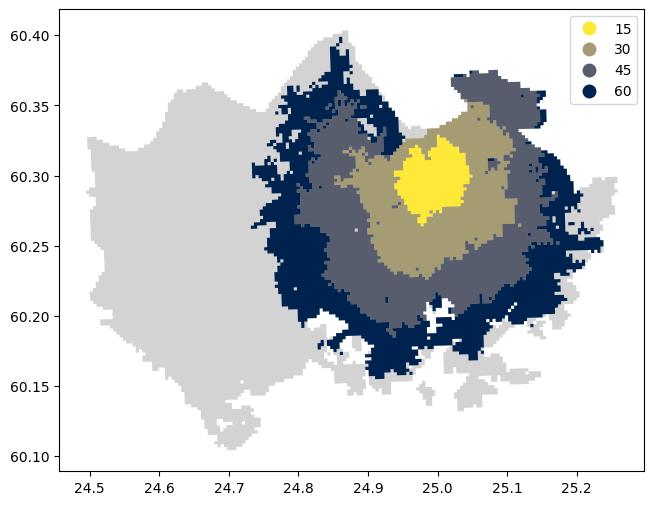

In [22]:
# A cell you can spam to see rangomly generated isochrones

ykr_id = grid.sample().iloc[0]["id"]
mode = random.choice(TRAVEL_MODES)
breakpoints = [15, 30, 45, 60]

print(mode, ykr_id)

traveltimes = read_matrix_to_df(
    Path(f"./data/Helsinki_Travel_Time_Matrix_2023/Helsinki_Travel_Time_Matrix_2023_travel_times_to_{ykr_id}.csv"),
    filetype="csv"
)

tt_grid = merge_traveltimes_to_grid(
    grid,
    traveltimes,
    mode,
)

tt_isochrones = dissolve_grid_to_isochrones(
    tt_grid,
    breakpoints=breakpoints,
    mode=mode,
)

plot_isochrones(tt_isochrones, grid)